In [11]:
import matplotlib.pylab as plt
import SimpleITK as sitk
import tensorflow as tf
import numpy as np
import glob
import cv2

In [1]:
class DataGenerator(object):
    
    def __init__(self, path = ''):
        self.path = path
        self.transforms = transforms
        self.malla = malla
    
    def read_image(self,path):
        reader = sitk.ImageFileReader()
        reader.SetFileName(path)
        return reader.Execute()                    
        
    def get_dataset(self):
        image_paths = [file for file in sorted(glob.glob(self.path + '/Case[0-9]?.mhd'))]
        label_paths = [file for file in sorted(glob.glob(self.path + '/Case*_segmentation.mhd'))]     
        
        dataset = zip(image_paths, label_paths)
        dataset = [self.input_parser(image, label) for image, label in zip(image_paths, label_paths)]
        
        return dataset
        
    def input_parser(self, image_path, label_path):

        image = self.read_image(image_path)
        label = self.read_image(label_path)

        sample = {'image':image, 'label':label}

        for transform in self.transforms:
            sample = transform(sample)

        image_np = sitk.GetArrayFromImage(sample['image'])
        label_np = sitk.GetArrayFromImage(sample['label'])
        
        image_np = np.asarray(image_np,np.float32)/255
        label_np = np.asarray(label_np,np.int32)
        
        return [image_np, label_np]    

In [2]:
class Normalization(object):
    """
    Normalize an image by setting its mean to zero and variance to one
    """

    def __init__(self):
        self.name = 'Normalization'

    def __call__(self, sample):
        resacleFilter = sitk.RescaleIntensityImageFilter()
        resacleFilter.SetOutputMaximum(255)
        resacleFilter.SetOutputMinimum(0)
        image, label = sample['image'], sample['label']
        image = resacleFilter.Execute(image)

        return {'image':image, 'label':label}
    

In [3]:
class RandomFlip(object):
    """
    Randomly flipping volumes across all three axis
    """
    def __init__(self):
        self.name = 'RandomFlip'

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # generating axis randomly
        flipaxes = np.random.random(3)>0.5

        flipimg = sitk.Flip(image, flipaxes.tolist())
        fliplab = sitk.Flip(label, flipaxes.tolist())

        return {'image':flipimg, 'label':fliplab}

In [4]:
class RandomSmoothing(object):
    """
    Randoml Gaussian smoothing
    """

    def __init__(self, prob):
        self.name = 'RandomSmoothing'
        self.prob = prob

    def __call__(self, sample):
    
        image, label = sample['image'], sample['label']
    
        if np.random.rand() < self.prob:
            image = sitk.RecursiveGaussian(image)

        return {'image':image, 'label':label}

In [5]:
class RandomNoise(object):
    """
    Randomly Gaussian Noise 
    """
    
    def __init__(self, prob):
        self.name = 'RandomNoise'
        self.prob = prob

    def __call__(self, sample):
    
        image, label = sample['image'], sample['label']
    
        if np.random.rand() < self.prob:
            image = sitk.AdditiveGaussianNoise(image)

        return {'image':image, 'label':label}

In [6]:
class HistogramEqualization(object):
    """
    Apply a power law adaptive histogram equalization controlled by the parameters alpha and beta
    """
    
    def __init__(self, Alpha, Beta, Radius):
        self.name = "HistogramEqualization"
        self.Alpha = Alpha
        self.Beta = Beta
        self.Radius = Radius
    
    def __call__(self, sample):
        
        image, label = sample['image'], sample['label']
        Equalization = sitk.AdaptiveHistogramEqualizationImageFilter()
        Equalization.SetAlpha(self.Alpha)
        Equalization.SetBeta(self.Beta)
        Equalization.SetRadius(self.Radius)
        image = Equalization.Execute(image)
        
        return {'image':image, 'label':label}

In [7]:
class HistogramMatching(object):
    """
    Histogram Matching with random images from training set (not applied to labels)
    """

    def __init__(self, data_dir, train_size=40, prob=0.5):
        self.name = 'Histogram Match'
        self.train_size = train_size
        self.data_dir = data_dir
        self.prob = prob

    def __call__(self, sample):
        
        image, label = sample['image'], sample['label']

        # histogram matching with random image from training set
        
        if np.random.random() <= self.prob:
            
            files = glob.glob(self.data_dir+'/Case*_segmentation.mhd')
            
            index = np.random.randint(0, self.train_size-1)
            file_name = files[index].replace('_segmentation', '')

            template = sitk.ReadImage(file_name)
            template = sitk.GetArrayFromImage(template)
            source = sitk.GetArrayFromImage(image) 
            oldshape = source.shape

            s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                                    return_counts=True)
            t_values, t_counts = np.unique(template, return_counts=True)

            s_quantiles = np.cumsum(s_counts).astype(np.float64)
            s_quantiles /= s_quantiles[-1]
            t_quantiles = np.cumsum(t_counts).astype(np.float64)
            t_quantiles /= t_quantiles[-1]

            interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

            image = interp_t_values[bin_idx].reshape(oldshape)
            image = sitk.GetImageFromArray(image)

        return {'image':image, 'label':label}

### Probando las tranformaciones de la imagen

In [18]:
#Probando con la imagen 1
image = sitk.ReadImage('train-data/Case00.mhd', sitk.sitkFloat32)
label = sitk.ReadImage('train-data/Case00_segmentation.mhd', sitk.sitkFloat32)
sample = {'image':image, 'label':label}

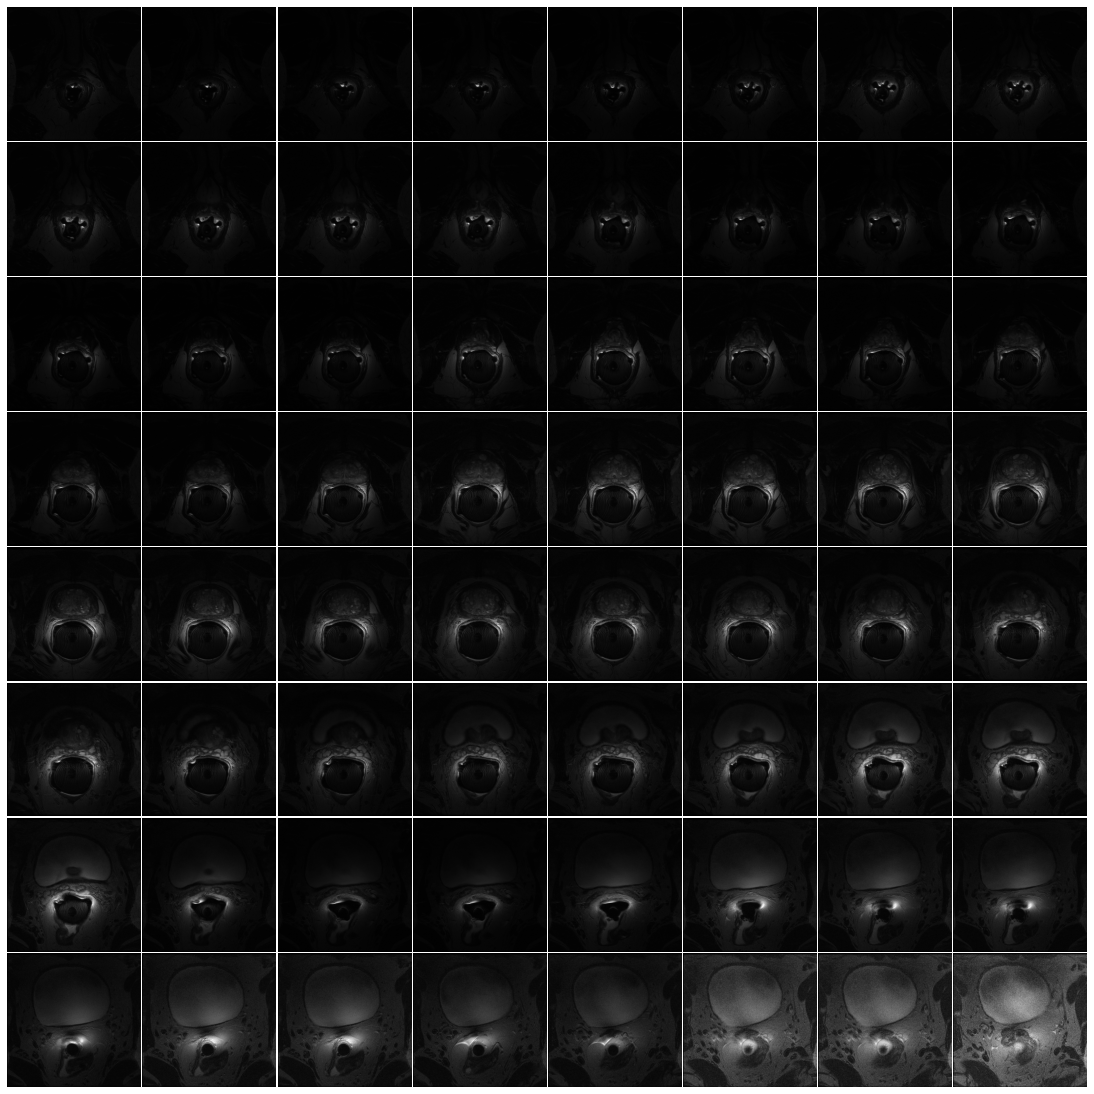

In [27]:
#Imagen Original

ct_scans1 = sitk.GetArrayFromImage(sample['image'])
plt.figure(figsize=(15,15))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans1.shape[0]):
    plt.subplot(8,8,i+1), plt.imshow(ct_scans1[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()

In [25]:
# Giro de los ejees de la imagen a partir de una probabilidad que sea mayor de 0.5

transformacion = RandomFlip()
image = transformacion(sample)

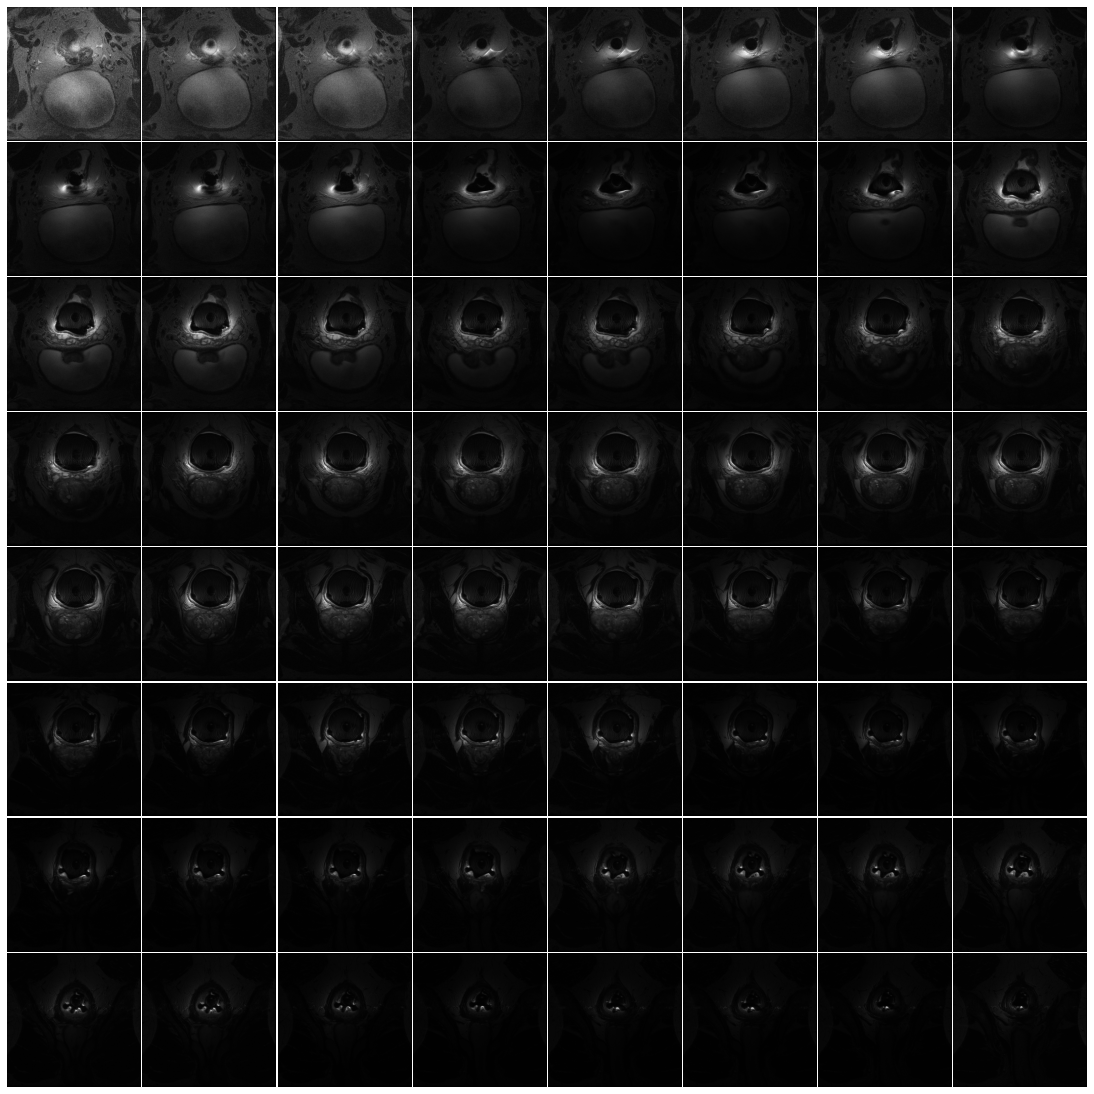

In [26]:
ct_scans1 = sitk.GetArrayFromImage(image['image'])
plt.figure(figsize=(15,15))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans1.shape[0]):
    plt.subplot(8,8,i+1), plt.imshow(ct_scans1[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()

In [28]:
#Ecualización del histograma

transformacion = HistogramEqualization(Alpha = 0.3, Beta = 0.3, Radius = [10, 10, 10])
image = transformacion(sample)

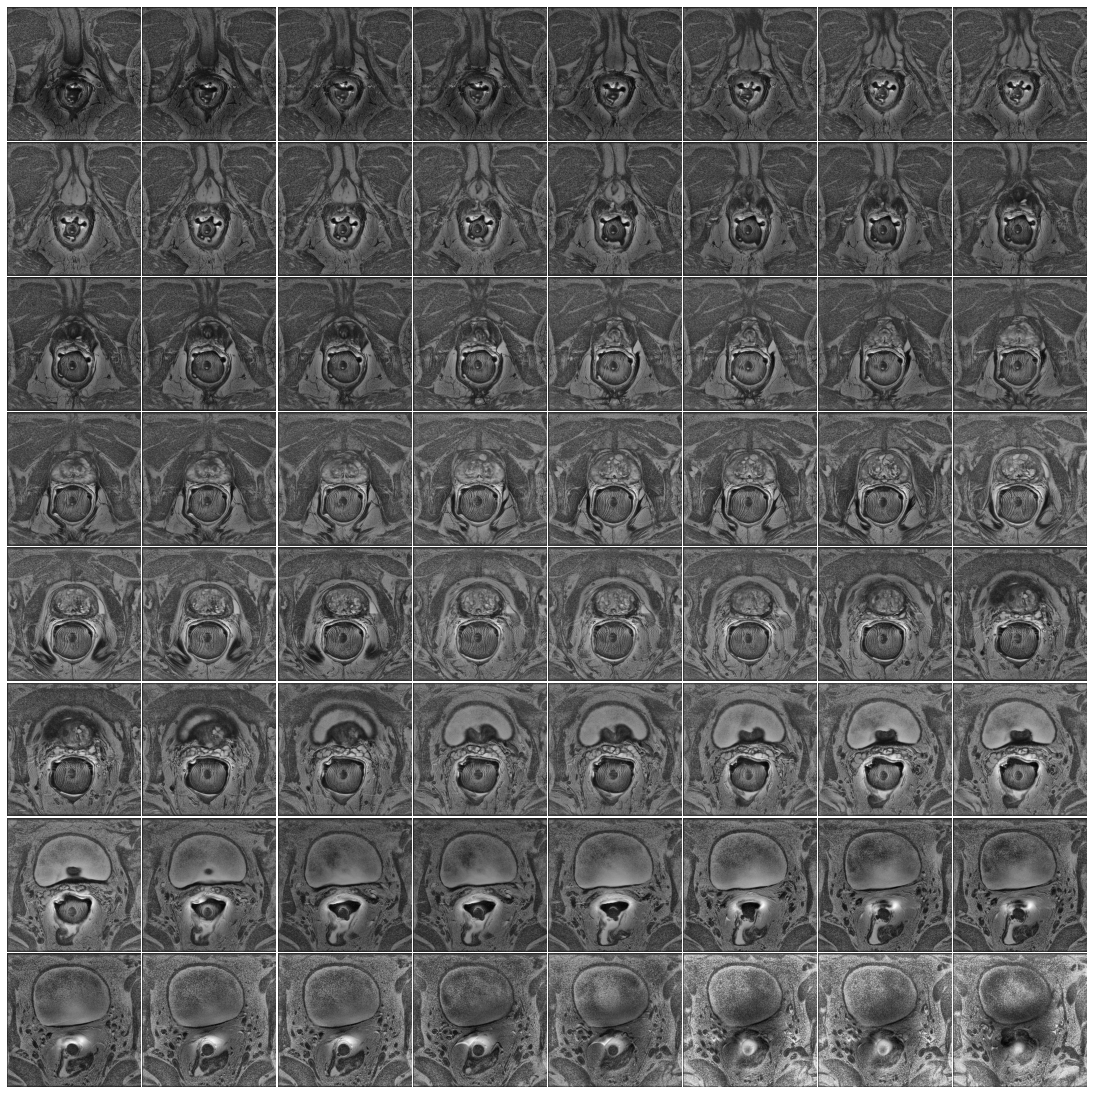

In [29]:
ct_scans1 = sitk.GetArrayFromImage(image['image'])
plt.figure(figsize=(15,15))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans1.shape[0]):
    plt.subplot(8,8,i+1), plt.imshow(ct_scans1[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()

In [48]:
# Mejora una imagen a partir de otra mediante un match entre historgramas de intesidad, este se hace cuando la probabilidad
# Generada de mayor a 0.5
transformacion = HistogramMatching(data_dir='train-data', train_size=40, prob=0.5)
image = transformacion(sample)

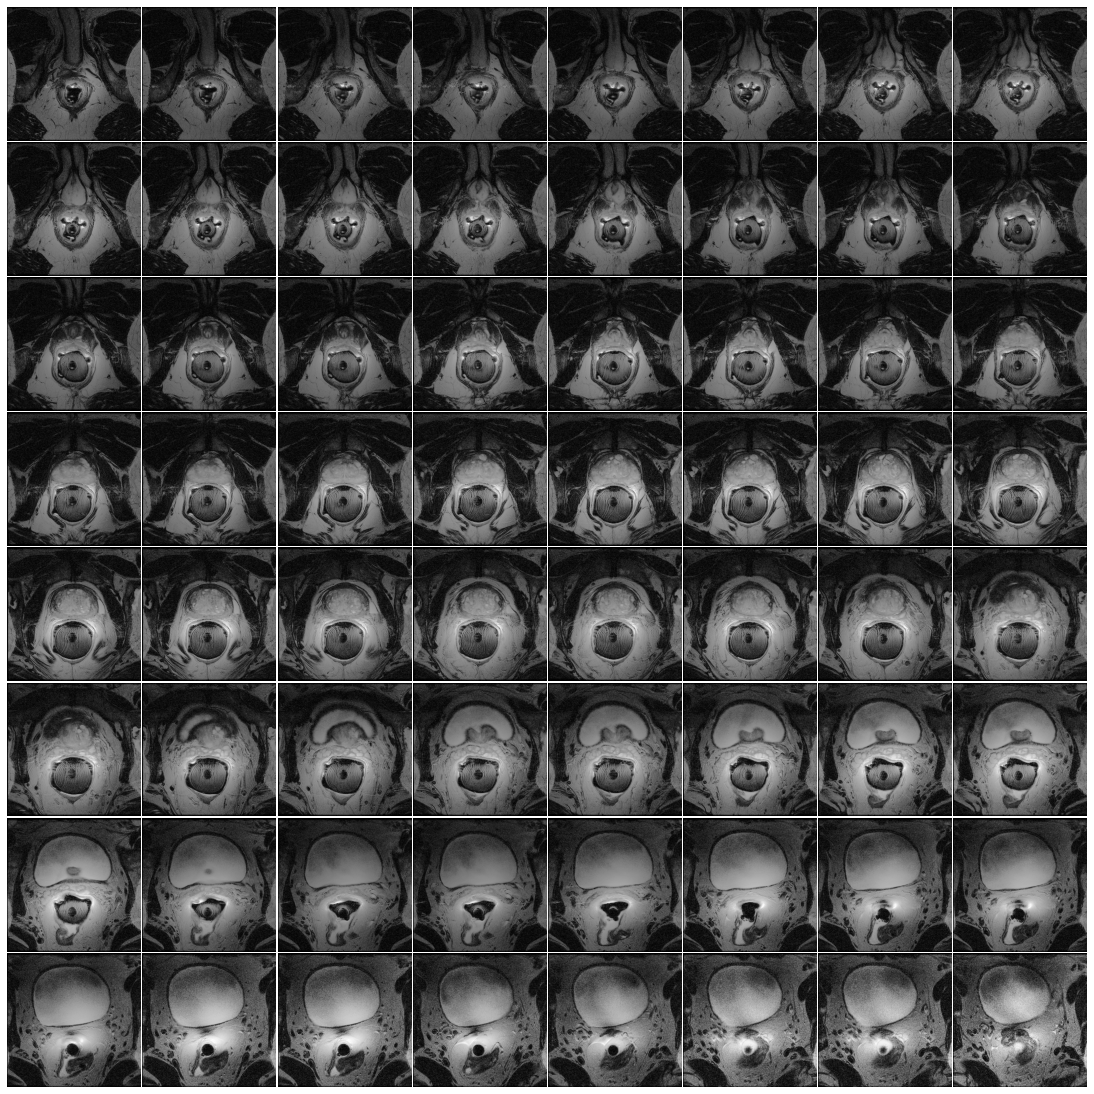

In [49]:
ct_scans1 = sitk.GetArrayFromImage(image['image'])
plt.figure(figsize=(15,15))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans1.shape[0]):
    plt.subplot(8,8,i+1), plt.imshow(ct_scans1[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()

In [56]:
#Suavizamiento aleatorio de la imagen a partir de una probabilidad

transformacion = RandomSmoothing(prob=1)
image = transformacion(sample)

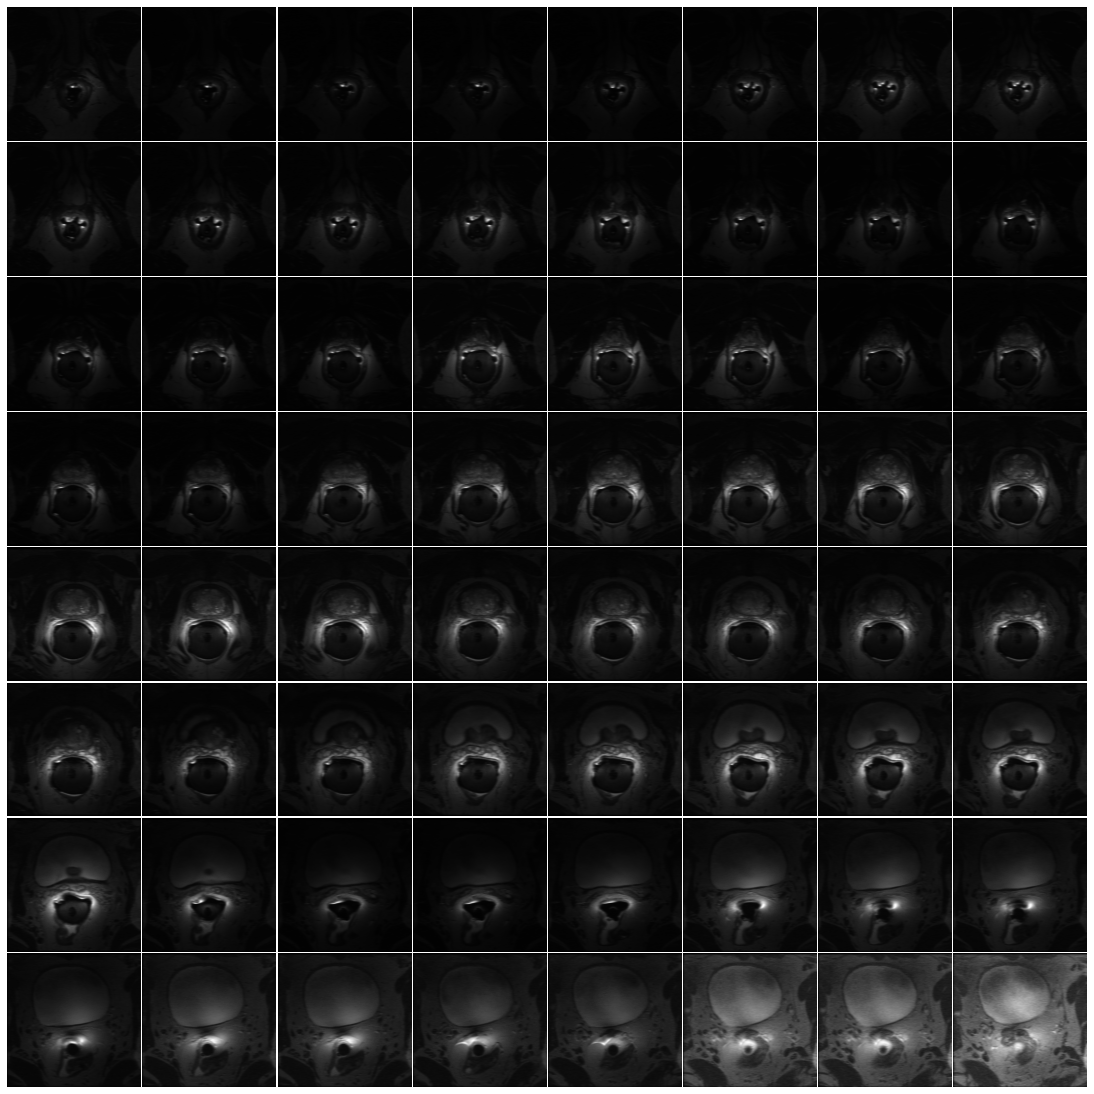

In [57]:
ct_scans1 = sitk.GetArrayFromImage(image['image'])
plt.figure(figsize=(15,15))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans1.shape[0]):
    plt.subplot(8,8,i+1), plt.imshow(ct_scans1[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()

In [64]:
#Ruido aleatorio en la imagen 

transformacion = RandomNoise(prob=0.9)
image = transformacion(sample)

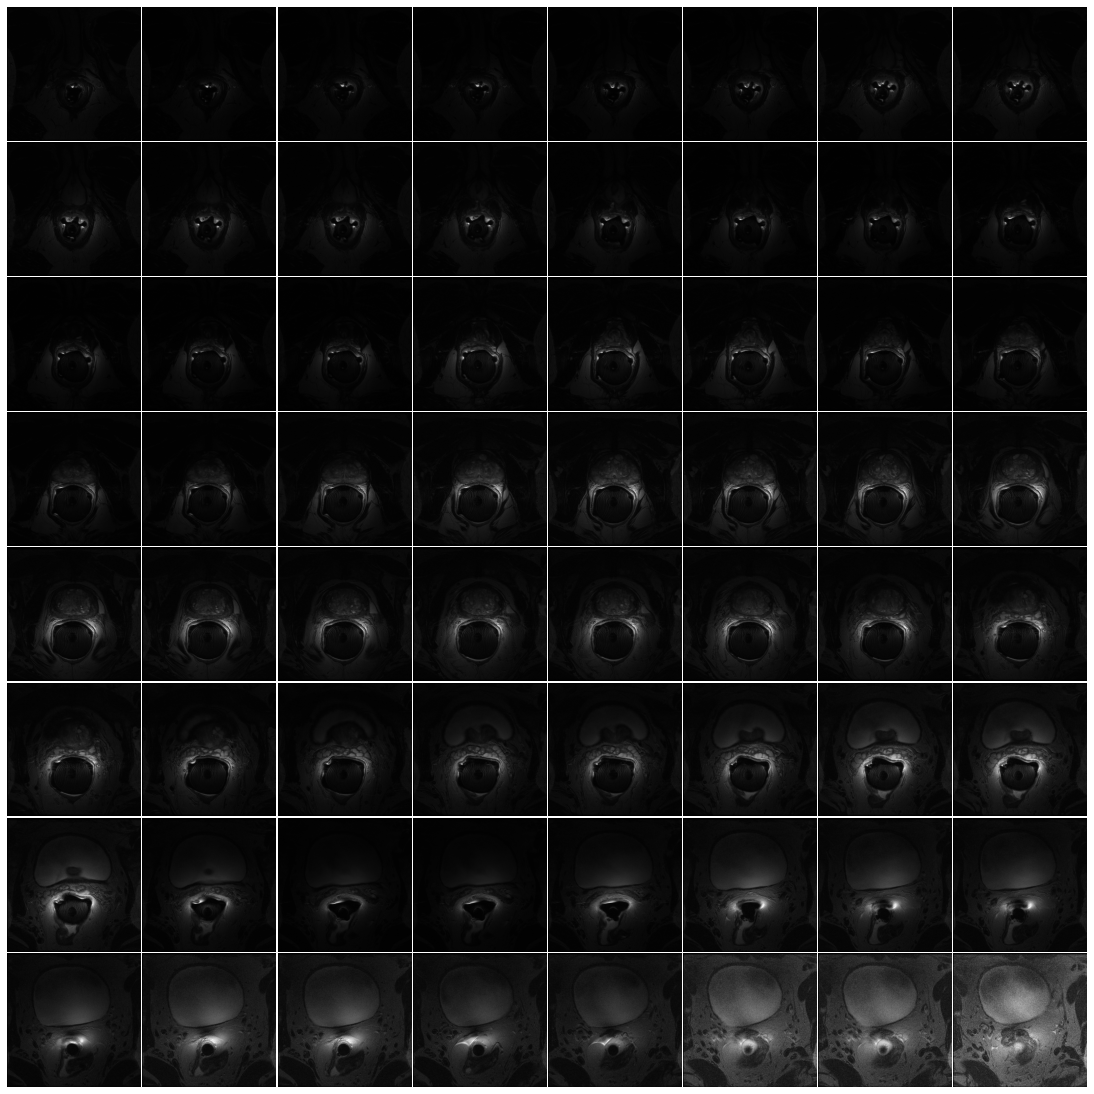

In [65]:
ct_scans1 = sitk.GetArrayFromImage(image['image'])
plt.figure(figsize=(15,15))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans1.shape[0]):
    plt.subplot(8,8,i+1), plt.imshow(ct_scans1[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()

In [66]:
#Normalización de la imagen 

transformacion = Normalization()
image = transformacion(sample)

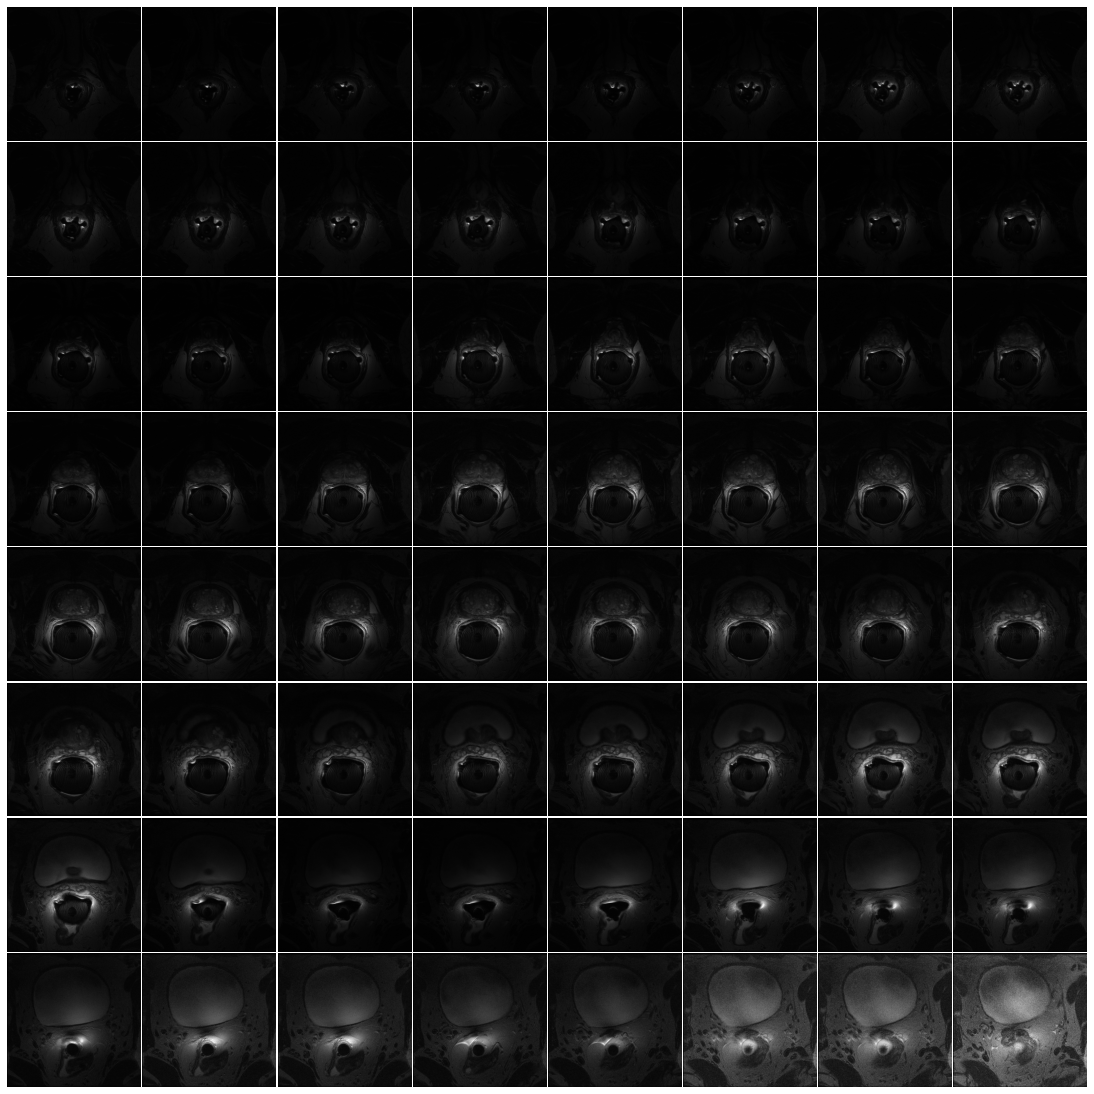

In [67]:
ct_scans1 = sitk.GetArrayFromImage(image['image'])
plt.figure(figsize=(15,15))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans1.shape[0]):
    plt.subplot(8,8,i+1), plt.imshow(ct_scans1[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()